In [1]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

## Generate 2D synthetic data

In [2]:
# 2D random data
x, y = make_classification(n_samples=1000,
                          n_features=2,
                          n_informative=1,
                          n_redundant=0,
                          n_clusters_per_class=1,
                          random_state=2020)

# normalize
x_norm = (x - x.min(axis=0)) / x.ptp(axis=0)

## Plot data

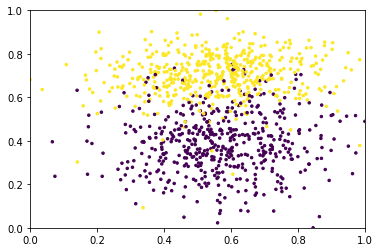

In [3]:
plt.figure()
plt.scatter(x_norm[:, 0], x_norm[:, 1], marker='.', c=y, s=25, edgecolor='face')
plt.grid(False)
plt.xlim(0, 1.0)
plt.ylim(0, 1.0)
plt.show()

## Split train and test data

In [4]:
train_indices = np.random.choice(len(x_norm), round(len(x_norm)*0.8), replace=False)
test_indices = np.array(list(set(range(len(x))) - set(train_indices)))

# one hot encoding
y_one = np.eye(len(set(y)))[y]

# x_train = tf.Variable(x_norm[train_indices], dtype=tf.float32)
# x_test = tf.Variable(x_norm[test_indices], dtype=tf.float32)
# y_train = tf.Variable(y_one[train_indices], dtype=tf.int32)
# y_test = tf.Variable(y_one[test_indices], dtype=tf.int32)

x_train = x_norm[train_indices]
x_test = x_norm[test_indices]
y_train = y_one[train_indices]
y_test = y_one[test_indices]

In [5]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(x_train[1])
print(y_train[1])

(800, 2)
(800, 2)
(200, 2)
(200, 2)
[0.58974866 0.73700764]
[0. 1.]


## kNN 

In [6]:
k = 9

# prediction
d0 = tf.expand_dims(x_test, axis=1)
print(d0.shape)
d1 = tf.subtract(x_train, d0)
print(d1.shape)
distance = tf.reduce_sum(tf.abs(d1), axis=2)

_, top_k_indices = tf.nn.top_k(tf.negative(distance), k=k)
top_k_labels = tf.gather(y_train, top_k_indices)

sum_predictions = tf.reduce_sum(top_k_labels, axis=1)
predictions = tf.argmax(sum_predictions, axis=1, output_type=tf.int32)

(200, 1, 2)
(200, 800, 2)


## Computing the accuracy

In [7]:
# get labels from test set
actual = tf.Variable(y[test_indices], dtype=tf.int32)

correct_count = tf.reduce_sum(tf.dtypes.cast(tf.math.equal(predictions, actual), tf.int32))
accuracy = correct_count / y_test.shape[0] * 100
print("Accuracy = ",accuracy.numpy(),"%")

Accuracy =  89.5 %


## Linear model

In [8]:
model = keras.Sequential([
    keras.layers.Dense(2, activation='softmax', input_shape=[2])
])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2)                 6         
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [11]:
model.fit(x_train, y_train, epochs=200, verbose=1)

Train on 800 samples
Epoch 1/200
800/800 [==============================] - 0s 450us/sample - loss: 0.6233 - accuracy: 0.7487
Epoch 2/200
800/800 [==============================] - 0s 29us/sample - loss: 0.6195 - accuracy: 0.7650
Epoch 3/200
800/800 [==============================] - 0s 41us/sample - loss: 0.6167 - accuracy: 0.7887
Epoch 4/200
800/800 [==============================] - 0s 38us/sample - loss: 0.6136 - accuracy: 0.8025
Epoch 5/200
800/800 [==============================] - 0s 39us/sample - loss: 0.6112 - accuracy: 0.8037
Epoch 6/200
800/800 [==============================] - 0s 39us/sample - loss: 0.6088 - accuracy: 0.8075
Epoch 7/200
800/800 [==============================] - 0s 29us/sample - loss: 0.6064 - accuracy: 0.8125
Epoch 8/200
800/800 [==============================] - 0s 37us/sample - loss: 0.6040 - accuracy: 0.8163
Epoch 9/200
800/800 [==============================] - 0s 37us/sample - loss: 0.6019 - accuracy: 0.8150
Epoch 10/200
800/800 [====================

800/800 [==============================] - 0s 33us/sample - loss: 0.3883 - accuracy: 0.9025
Epoch 156/200
800/800 [==============================] - 0s 29us/sample - loss: 0.3874 - accuracy: 0.9000
Epoch 157/200
800/800 [==============================] - 0s 33us/sample - loss: 0.3867 - accuracy: 0.9025
Epoch 158/200
800/800 [==============================] - 0s 31us/sample - loss: 0.3858 - accuracy: 0.9025
Epoch 159/200
800/800 [==============================] - 0s 35us/sample - loss: 0.3850 - accuracy: 0.9025
Epoch 160/200
800/800 [==============================] - 0s 35us/sample - loss: 0.3843 - accuracy: 0.9013
Epoch 161/200
800/800 [==============================] - 0s 32us/sample - loss: 0.3836 - accuracy: 0.9038
Epoch 162/200
800/800 [==============================] - 0s 24us/sample - loss: 0.3827 - accuracy: 0.9025
Epoch 163/200
800/800 [==============================] - 0s 30us/sample - loss: 0.3819 - accuracy: 0.9025
Epoch 164/200
800/800 [==============================] - 0s 

In [12]:
model.evaluate(x_test, y_test, verbose=2)

200/1 - 0s - loss: 0.3035 - accuracy: 0.8950


[0.36416222095489503, 0.895]

## Adversarial Examples

In [13]:
print(x_test[:1])
print(y_test[0])

[[0.73882985 0.24302252]]
[1. 0.]


In [14]:
prediction = model.predict(x_test[:1])
prediction[0]

array([0.91984427, 0.08015571], dtype=float32)

In [15]:
loss_func = keras.losses.BinaryCrossentropy()

def create_adversarial_perturbation(input_clean, input_label):
    input_tensor = tf.constant(input_clean, dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(input_tensor)
        pred = model(input_tensor)
        loss = loss_func(input_label, pred)
        
    gradient = tape.gradient(loss, input_tensor)
    return tf.sign(gradient)

### Creating single adversarial example

In [16]:
perturbation = create_adversarial_perturbation(x_test[:1], y_test[0])
perturbation

<tf.Tensor: id=16436, shape=(1, 2), dtype=float32, numpy=array([[-1.,  1.]], dtype=float32)>

In [17]:
epsilon = 0.15
x_ad =  x_test[:1] + epsilon * perturbation
print(x_test[:1])
print(x_ad.numpy())

[[0.73882985 0.24302252]]
[[0.5888299  0.39302254]]


In [18]:
pred_ad = model.predict(x_ad)
pred_ad

array([[0.753271  , 0.24672902]], dtype=float32)

### Adversarial examples from full test set

In [19]:
perturbations = create_adversarial_perturbation(x_test, y_test)
print(perturbations[:10])

tf.Tensor(
[[-1.  1.]
 [-1.  1.]
 [-1.  1.]
 [-1.  1.]
 [-1.  1.]
 [ 1. -1.]
 [-1.  1.]
 [-1.  1.]
 [ 1. -1.]
 [-1.  1.]], shape=(10, 2), dtype=float32)


In [20]:
x_ad = x_test + epsilon * perturbations
print(x_test[:10])
print(x_ad[:10])

[[0.73882985 0.24302252]
 [0.86412267 0.05134149]
 [0.30887721 0.21469168]
 [0.46141646 0.32153748]
 [0.7600341  0.5042726 ]
 [0.44443712 0.80689819]
 [0.4155306  0.21799824]
 [0.9720861  0.5160419 ]
 [0.66281481 0.81341298]
 [0.39396553 0.361196  ]]
tf.Tensor(
[[0.5888299  0.39302254]
 [0.71412265 0.2013415 ]
 [0.1588772  0.36469167]
 [0.31141645 0.4715375 ]
 [0.6100341  0.65427256]
 [0.5944371  0.65689814]
 [0.2655306  0.36799824]
 [0.8220861  0.66604185]
 [0.81281483 0.6634129 ]
 [0.24396554 0.511196  ]], shape=(10, 2), dtype=float32)


In [21]:
model.evaluate(x_ad, y_test, verbose=2)

200/1 - 0s - loss: 0.7776 - accuracy: 0.4100


[0.9051263904571534, 0.41]

### Plot graph

In [22]:
test_positive_indices = [idx for idx, val in enumerate(y_test) if val[0] == 1]
print(len(test_positive_indices))

87


In [23]:
print(x_test[list(test_positive_indices)][:10])

[[0.73882985 0.24302252]
 [0.86412267 0.05134149]
 [0.30887721 0.21469168]
 [0.46141646 0.32153748]
 [0.7600341  0.5042726 ]
 [0.4155306  0.21799824]
 [0.9720861  0.5160419 ]
 [0.39396553 0.361196  ]
 [0.4999818  0.36147773]
 [0.82732668 0.34959   ]]


In [24]:
print(len(x_ad))
ad_pred = model.predict(x_ad)
ad_result = tf.math.argmax(ad_pred, axis=1)
print(ad_result.numpy())

200
[0 0 0 0 1 1 0 1 1 1 1 1 0 0 1 0 0 1 0 1 1 1 0 0 0 0 0 1 1 0 0 1 1 0 1 0 1
 0 0 0 0 1 1 1 0 1 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0
 1 0 1 1 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 1 1 0 0 0 1 1 1 1 1 0 0 1 1
 1 0 1 0 1 0 1 1 1 0 1 0 0 0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 1 1 1 1 1 1 1 0 1
 1 0 1 1 0 1 1 1 1 1 0 1 1 1 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 1 1 0 1 0
 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0]


In [25]:
len(ad_result.numpy()[list(test_positive_indices)])

87

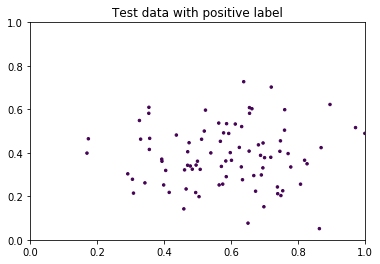

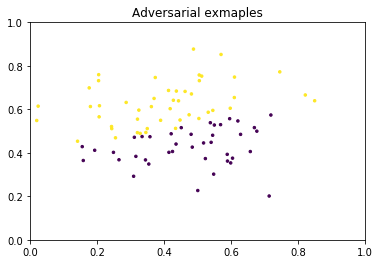

In [26]:
plt.figure()
plt.scatter(x_test[list(test_positive_indices)][:, 0], 
            x_test[list(test_positive_indices)][:, 1], 
            marker='.', 
            c=y[test_indices][list(test_positive_indices)], 
            s=25, 
            edgecolor='face')
plt.grid(False)
plt.ylim(0, 1.0)
plt.xlim(0, 1.0)
plt.title('Test data with positive label')
plt.show()

plt.figure()
plt.scatter(x_ad.numpy()[list(test_positive_indices)][:, 0], 
            x_ad.numpy()[list(test_positive_indices)][:, 1], 
            marker='.', 
            c=ad_result.numpy()[list(test_positive_indices)], 
            s=25, 
            edgecolor='face')
plt.grid(False)
plt.ylim(0, 1.0)
plt.xlim(0, 1.0)
plt.title('Adversarial exmaples')
plt.show()


## Applicability Domain

In [27]:
# implementing 3-step AD

def check_applicability(input_data):
    applicability = 1.0
    return applicability

In [28]:
def check_reliability(input_data):
    reliability = 1.0
    return reliability

In [29]:
def check_decidability(input_data):
    decidability = 1.0
    return decidability

In [30]:
threshold_applicability = 0.6
threshold_reliability = 0.6
threshold_decidability = 0.6

# Applicability Domain pipline

def check_AD(sample):
    result = False
    applicability = check_applicability(sample)
    if applicability >= threshold_applicability:
        reliability = check_reliability(sample)
        if reliability >= threshold_reliability:
            decidability = check_decidability(sample)
            if decidability >= threshold_decidability:
                print('Passed AD test')
                return True
            else:
                print(f'Failed Decidability Test (Decidability = {decidability:4.3f}, Threshold = {threshold_decidability:4.3f})')
                return False
        else:
            print(f'Failed Reliability Test (Reliability = {reliability:4.3f}, Threshold = {threshold_reliability:4.3f})')
            return False
    else:
        print(f'Failed Applicability Test (Applicability = {applicability:4.3f}, Threshold = {threshold_applicability:4.3f})')
    return False

In [31]:
print(x_ad[0])
print(check_AD(x_ad[0]))

tf.Tensor([0.5888299  0.39302254], shape=(2,), dtype=float32)
Passed AD test
True
